In [1]:
import locale
import numpy as np

from ipywidgets import interact, FloatSlider
import ipywidgets as widgets

# import matplotlib pyplot commands
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.pyplot as plt 

# Show Plots in the Notebook
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize']= (10, 8)   # set Chart Size
plt.rcParams['font.size'] = 14            # set Font size in Chart

# 'style' the plot like fivethirtyeight.com website
plt.style.use('bmh')

In [3]:
def make_pattern(esc, life):
    pat = np.ones(life - 1) * (1 + esc)
    return np.insert(pat.cumprod(), 0, [0.0, 1.0])

In [4]:
def as_currency(amount, pos=None):
    if amount >= 0:
        return '${:,.0f}'.format(amount)
    else:
        return '(${:,.0f})'.format(-amount)

In [5]:
plt.rc('ytick',labelsize=16)
shared_ax = None
def cash_graph(cash_flow, plot_num, title, discount_rate):
    global shared_ax
    
    y_formatter = FuncFormatter(as_currency)

    width = 0.35
    if plot_num==1:
        shared_ax = plt.subplot(310 + plot_num)
        shared_ax.get_xaxis().set_ticks([])
        shared_ax.yaxis.set_major_formatter(y_formatter)
    else:
        ax = plt.subplot(310 + plot_num, sharey=shared_ax)
        ax.yaxis.set_major_formatter(y_formatter)
        if plot_num != 3:
            ax.get_xaxis().set_ticks([])
    if plot_num == 3:
        plt.xlabel('Year')
    plt.bar(np.arange(len(cash_flow)) - width*0.5, cash_flow, width)
    plt.xlim(-0.3, 14.5)
    plt.title(title, fontsize=26)
    
    # determine IRR
    try:
        irr = '{:.1%}'.format(np.irr(cash_flow))   # in %
    except:
        irr = ''
    # Net Present Value
    npv = as_currency(np.npv(discount_rate, cash_flow))
    plt.annotate(
        'Net Present Value: %s\nInternal Rate of Return: %s' % (npv, irr),
         xy=(0.4, 0.25),
        xycoords='axes fraction',
        fontsize=24,
        color='green'
    )
    

In [7]:
def model(elec_price, util_rebate, oil_price, hp_cop, util_admin_cost):
    # Economic Factors
    discount_rate = 0.05
    elec_esc = 0.02 + 0.0096          # Heat Pump Electric Rate Escalation, DOE Western Region Estimate
    elec_prod_esc = 0.03             # Electric Production Cost Escalation, 10 years of adding $0.25/MCF to $7/MCF
    oil_esc = 0.02 + 0.0204           # Oil Price Escalation, DOE Western Region estimate

    # Electricity and Fuel Prices
    elec_prod_hp = 0.065 / 0.95      # Incremental Electricity Production Cost
    elec_prod_hp = 0.1 / 0.95        # High End of Incremental Production Cost (includes incremental capital)
    sales_tax = 0.0                  # Borough is 3% plus city sales tax of Soldotna 3%, Homer 4.5%, Kenai 3%

    # Heat Pump Characteristics
    life = 14
    hp_cost = 4500.

    # Displaced Heating Fuel
    gal_saved = 500    # oil gallons
    oil_effic = 0.8
    # Oil heating system kWh per MMBtu of heat delivered.  Boiler is about 2, 
    # Toyotove 4, furnace 5 - 9 kWh/MMBtu.
    # This will be used to calculated kWh avoided due to reduced oil heating 
    # system use.
    kwh_per_mmbtu = 4.0   

    elec_pat = make_pattern(elec_esc, life)
    elec_prod_pat = make_pattern(elec_prod_esc, life)
    oil_pat = make_pattern(oil_esc, life)

    # Heat Pump Impacts
    cash = np.zeros(life + 1)
    cash += oil_pat * gal_saved * oil_price * (1 + sales_tax)
    hp_kwh = gal_saved * 135000 * oil_effic / 3412. / hp_cop
    avoided_kwh = gal_saved * 135000 * oil_effic / 1e6 * kwh_per_mmbtu
    net_kwh = hp_kwh - avoided_kwh
    print(hp_kwh, avoided_kwh, net_kwh, 'kWh')
    cash += -elec_pat * elec_price * net_kwh * (1 + sales_tax)
    cash[0] += -hp_cost * (1 + sales_tax) + util_rebate

    # Utility Cash Flow
    cash_util = np.zeros(life + 1)
    cash_util += net_kwh * elec_price * elec_pat
    cash_util += -net_kwh * elec_prod_hp * elec_prod_pat
    cash_util[0] += -util_rebate - util_admin_cost

    #print(cash)
    #print(cash_util)

    plt.figure(figsize=(12,12))
    cash_graph(cash,  1, 'Heat Pump Customer Cash Flow', discount_rate)
    cash_graph(cash_util, 2, 'Utility Cash Flow', discount_rate)
    cash_graph(cash + cash_util, 3, 'Heat Pump Customer + Utility Cash Flow', discount_rate)

    plt.tight_layout()
    plt.savefig('cash_flow.png')

6087.1133555776 216.0 5871.1133555776 kWh


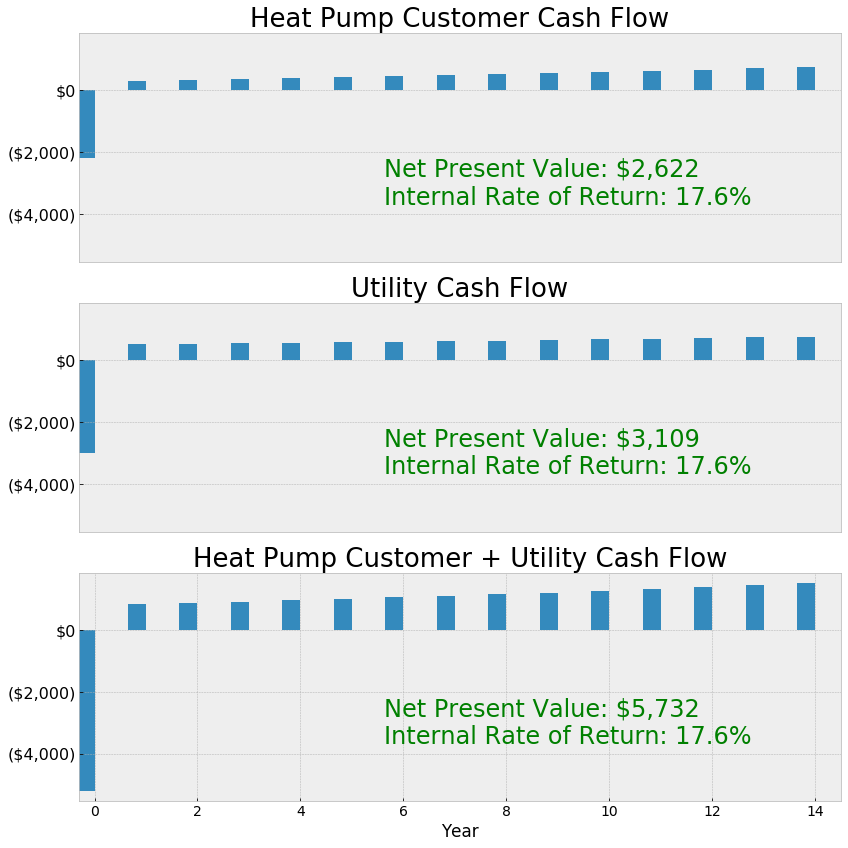

In [18]:
model(0.1939, 2300, 2.90, 2.6, 700)